<a href="https://colab.research.google.com/github/poliduckie/MPC/blob/main/multiclass_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
# now we can see Drive as local

Mounted at /content/gdrive


In [2]:
import os
from PIL import Image
from numpy import asarray
import numpy as np
import keras
from keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2 as cv2
import sys

In [3]:
# load every image into memory
ORIG = '/content/gdrive/MyDrive/images_stable/rgb_orig_rand'
TARGET = '/content/gdrive/MyDrive/images_stable/rgb_ss'

n = 100
TRAIN_DIM = 60
x_train = []
y_train = []

for i in range(n):
  if os.path.isfile(os.path.join(ORIG, f'{i}.png')):
    img = Image.open(os.path.join(ORIG, f'{i}.png'))
    data = asarray(img)
    x_train.append(data)
    img = Image.open(os.path.join(TARGET, f'{i}_seg.png'))
    data = asarray(img)
    y_train.append(data)

drive.flush_and_unmount()

In [4]:
!git clone https://github.com/poliduckie/MPC.git
%cd MPC
!ls

Cloning into 'MPC'...
remote: Enumerating objects: 3192, done.
remote: Counting objects: 100% (3192/3192), done.
remote: Compressing objects: 100% (1434/1434), done.
remote: Total 3192 (delta 1752), reused 3111 (delta 1727), pack-reused 0
Receiving objects: 100% (3192/3192), 59.74 MiB | 12.34 MiB/s, done.
Resolving deltas: 100% (1752/1752), done.
/content/MPC
dataset_generation		  README.md
gym-duckietown			  ReinforcementLearning
LaneDetection_test.ipynb	  UNet_full_res.ipynb
multiclass_segmentation_v2.ipynb  UNet_full_res_model
One_LaneDetection_test.ipynb	  U_net_model.ipynb
OpenCV


In [5]:
x_train = [np.delete(elem, [False, False, False, True], axis=2) for elem in x_train]
y_train = [np.delete(elem, [False, False, False, True], axis=2) for elem in y_train]
print(len(x_train))

85


In [6]:
x_test = x_train[TRAIN_DIM:]
x_train = x_train[:TRAIN_DIM]
y_test = y_train[TRAIN_DIM:]
y_train = y_train[:TRAIN_DIM]

#print(x_train[0])
x_train = np.array(x_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
y_train = np.array(y_train)

In [7]:
def separate_classes(img):
  img = np.copy(img)
  # remove magenta
  img[np.all(img == np.array([255,0,254]), axis=-1)] = np.array([0,0,0])
  img_white = np.copy(img)
  img_yellow = np.copy(img)
  img_no_line = np.copy(img)
  # white line
  img_white[np.all(img_white == np.array([255,255,0]), axis=-1)] = np.array([0,0,0])
  img_white = resize(img_white, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range='true' )
  img_white=img_white[:,:,:1]
  img_white = np.squeeze(img_white)
  img_white = img_white/255.

  # yellow line
  img_yellow[np.all(img_yellow == np.array([255,255,255]), axis=-1)] = np.array([0,0,0])
  img_yellow[np.all(img_yellow == np.array([255,255,0]), axis=-1)] = np.array([255,255,255])
  img_yellow = resize(img_yellow, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range='true' )
  img_yellow=img_yellow[:,:,:1]
  img_yellow = np.squeeze(img_yellow)
  img_yellow = img_yellow/255.

  # not a line
  img_no_line[np.all(img_no_line == np.array([255,255,255]), axis=-1)] = np.array([255,255,0])
  img_no_line[np.all(img_no_line == np.array([0,0,0]), axis=-1)] = np.array([255,255,255])
  img_no_line[np.all(img_no_line == np.array([255,255,0]), axis=-1)] = np.array([0,0,0])
  img_no_line = resize(img_no_line, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range='true' )
  img_no_line=img_no_line[:,:,:1]
  img_no_line = np.squeeze(img_no_line)
  img_no_line = img_no_line/255.

  img_masks = np.array([img_white,img_yellow,img_no_line])
  return img_masks

In [8]:
IMG_WIDTH = 320
IMG_HEIGHT = 240
IMG_CHANNELS = 3
N_CLASSES = 3  #  central line (yellow), lateral line (white) and not a line

LENGTH = y_train.shape[0]

Y_train = []

for i in range(LENGTH):
  img = np.copy(y_train[i])
  img = separate_classes(img)
  Y_train.append(img)
  
y_train = np.array(Y_train)
print(y_train.shape)
#y_train = np.swapaxes(np.swapaxes(y_train, 1, 2), 2, 3)
y_train = np.moveaxis(y_train, 1, -1)
print(y_train[0].shape)

(60, 3, 240, 320)
(240, 320, 3)


In [9]:
LENGTH = y_test.shape[0]

Y_test = []

for i in range(LENGTH):
  img = np.copy(y_test[i])
  img = separate_classes(img)
  Y_test.append(img)
  
y_test = np.array(Y_test)
#y_test = np.swapaxes(np.swapaxes(y_test, 1, 2), 2, 3)
y_test = np.moveaxis(y_test, 1, -1)
print(y_test[0].shape)

(240, 320, 3)


In [10]:
BATCH_SIZE = 5

If the model isn't sufficiently accurate we can try to enlarge conv2D layers' outputs

In [11]:
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x:x /255)(inputs)

In [12]:
c1 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

In [13]:
c2 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

In [14]:
c3 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.1)(c3)
c3 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

In [15]:
c4 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.1)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

In [16]:
c5 = tf.keras.layers.Conv2D(256, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.1)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(c5)

In [17]:
u6 = tf.keras.layers.Convolution2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4]) #merge with old layer
c6 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.1)(c6)
c6 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(c6)

In [18]:
u7 = tf.keras.layers.Convolution2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])  #merge with old layer
c7 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.1)(c7)
c7 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(c7)

In [19]:
u8 = tf.keras.layers.Convolution2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])  #merge with old layer
c8 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(c8)

In [20]:
u9 = tf.keras.layers.Convolution2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1])  #merge with old layer
c9 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(c9)

In [21]:
outputs = tf.keras.layers.Conv2D(N_CLASSES, (1,1), activation = 'softmax')(c9)

In [22]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy')
model.summary()

checkpointer = tf.keras.callbacks.ModelCheckpoint('duckie_street.h5', verbose=1, save_best_only=True)
callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=100, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs')]
results = model.fit(x_train,y_train, validation_split=0.1, batch_size = BATCH_SIZE, epochs=100, callbacks=callbacks)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 240, 320, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 240, 320, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [23]:
import random
import matplotlib.pyplot

seed = 42
np.random.seed = seed

25


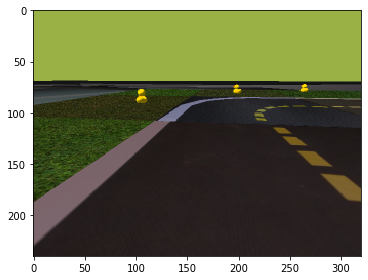

1/1 [==============================] - 0s 479ms/step


/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


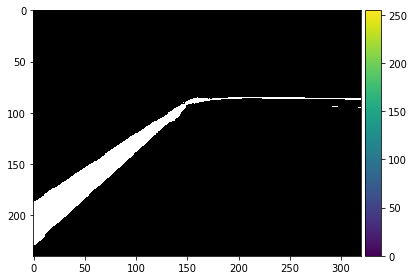

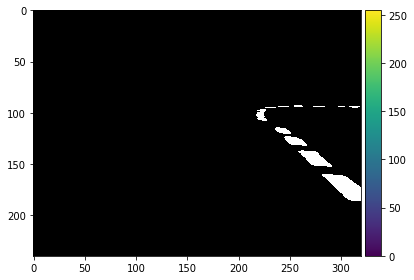

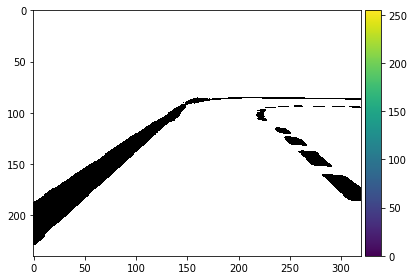

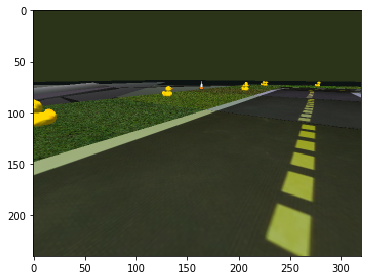

1/1 [==============================] - 0s 184ms/step


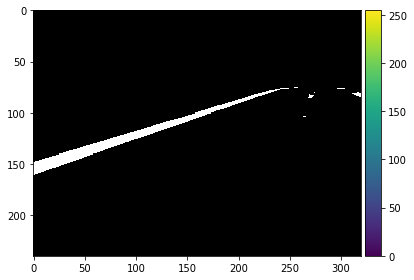

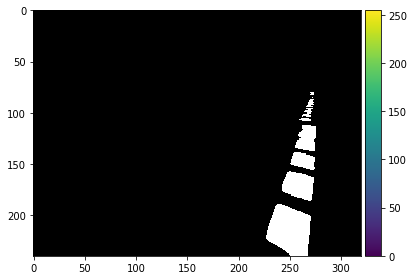

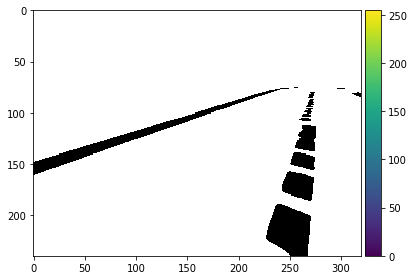

In [24]:
%matplotlib inline
TEST_LENGTH = x_test.shape[0]
print(TEST_LENGTH)
idx1 = np.random.randint(0,TEST_LENGTH)
idx2 = np.random.randint(0,TEST_LENGTH)

# 1
imshow(x_test[idx1])
plt.show()

prediction = model.predict(x_test[idx1].reshape((1,IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
prediction = np.squeeze(prediction)

masks = []
max_vals = prediction.max(axis=-1) #take the max value along the probability axis
for i in range(N_CLASSES):
  masks.append(prediction[:,:,i] == max_vals)
  masks[i] = np.array(masks[i], dtype=int)
  masks[i] = np.array([masks[i]*255 for _ in range(3)])
  masks[i] = np.moveaxis(masks[i], 0, -1)
  imshow(masks[i])
  plt.show()



# 2
imshow(x_test[idx2])
plt.show()

prediction = model.predict(x_test[idx2].reshape((1,IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
prediction = np.squeeze(prediction)

masks = []
max_vals = prediction.max(axis=-1) #take the max value along the probability axis
for i in range(N_CLASSES):
  masks.append(prediction[:,:,i] == max_vals)
  masks[i] = np.array(masks[i], dtype=int)
  masks[i] = np.array([masks[i]*255 for _ in range(3)])
  masks[i] = np.moveaxis(masks[i], 0, -1)
  imshow(masks[i])
  plt.show()

In [26]:
drive.mount('/content/gdrive')

model.save('/content/gdrive/MyDrive/multiclass_segmentation_model')

drive.flush_and_unmount()

Mounted at /content/gdrive
